In [1]:
import sys
sys.path.append('..')
import umbrella_mesh
import elastic_rods
import linkage_vis
from umbrella_mesh import UmbrellaEnergyType
from bending_validation import suppress_stdout as so
from visualization_helper import *
import importlib, pipeline_helper

In [2]:
importlib.reload(pipeline_helper)
from pipeline_helper import allEnergies, allGradientNorms, allDesignObjectives, allDesignGradientNorms

In [3]:
import numpy as np
import numpy.linalg as la

In [4]:
import pickle, gzip

### Initial Deployment

In [5]:
name = 'saddle'

In [6]:
input_path = '../../data/{}.json'.format(name)

In [7]:
from load_jsondata import read_data
input_data, io = read_data(filepath = input_path)
import mesh
target_mesh = mesh.Mesh(input_data['target_v'], input_data['target_f'])

In [8]:
curr_um = umbrella_mesh.UmbrellaMesh(io)
thickness = io.material_params[6]
curr_um.targetDeploymentHeight = thickness

In [9]:
curr_um.energy(UmbrellaEnergyType.Full)

9.18987434388728e-28

In [10]:
target_height_multiplier = 5

#### Pin Rigid Motion



In [11]:
use_pin = False

In [12]:
driver = curr_um.centralJoint()
jdo = curr_um.dofOffsetForJoint(driver)
fixedVars = (list(range(jdo, jdo + 6)) if use_pin else []) + curr_um.rigidJointAngleDoFIndices()

In [13]:
import py_newton_optimizer
OPTS = py_newton_optimizer.NewtonOptimizerOptions()
OPTS.gradTol = 1e-10
OPTS.verbose = 1
OPTS.beta = 1e-6
OPTS.niter = 300
OPTS.verboseNonPosDef = False

In [14]:
rod_colors = []
for ri in range(curr_um.numSegments()):
    rod_colors.append(np.ones(curr_um.segment(ri).rod.numVertices()) * ri)

In [15]:
import mesh
view = linkage_vis.LinkageViewerWithSurface(curr_um, target_mesh, width=1024, height=600)
# view = linkage_vis.LinkageViewer(curr_um, width=1024, height=600)
# view.update(scalarField = rod_colors)
set_surface_view_options(view, color = 'green', surface_color = 'gray', umbrella_transparent = False, surface_transparent = True)
view.averagedMaterialFrames = True
view.showScalarField(rod_colors)
view.show()

Renderer(camera=PerspectiveCamera(aspect=1.7066666666666668, children=(PointLight(color='#999999', position=(0…

In [16]:
allEnergies(curr_um)

{'Full': 9.189874343887279e-28,
 'Elastic': 9.189874343887279e-28,
 'Deployment': 0.0,
 'Repulsion': 0.0,
 'Attraction': 0.0,
 'AngleBoundPenalty': 0.0}

In [17]:
allGradientNorms(curr_um)

{'Full': 3.0741777012340675e-12,
 'Elastic': 3.0741777012340675e-12,
 'Deployment': 0.0,
 'Repulsion': 0.0,
 'Attraction': 0.0,
 'AngleBoundPenalty': 0.0}

In [18]:
curr_um.deploymentForceType = umbrella_mesh.DeploymentForceType.LinearActuator

In [19]:
curr_um.angleBoundEnforcement = umbrella_mesh.AngleBoundEnforcement.Penalty

In [20]:
from pipeline_helper import set_joint_vector_field, show_center_joint_normal, show_joint_normal

In [21]:
view.update(vectorField = show_center_joint_normal(curr_um, curr_um.rigidJoints()))                 

In [22]:
view.update(vectorField = show_joint_normal(curr_um, [curr_um.getUmbrellaCenterJi(19, 0)]))                 

In [23]:
from equilibrium_solve_analysis import EquilibriumSolveAnalysis
eqays = EquilibriumSolveAnalysis(curr_um)
def eqm_callback(prob, i):
    eqays.record(prob)
    if (i % 2 == 0):
        view.update(scalarField=rod_colors)

In [24]:
# curr_um.deploymentForceType = umbrella_mesh.DeploymentForceType.Constant
curr_um.targetDeploymentHeight = thickness * target_height_multiplier
curr_um.repulsionEnergyWeight = 0
curr_um.attractionWeight = 1e-1
curr_um.setHoldClosestPointsFixed(False)
curr_um.scaleInputPosWeights(0.1)
tsf = curr_um.getTargetSurface()
tsf.W_diag_joint_pos[0], tsf.Wsurf_diag_umbrella_sample_pos[0]

(0.00045662100456621003, 0.004109589041095891)

In [25]:
allGradientNorms(curr_um)

{'Full': 0.00025309521291861585,
 'Elastic': 3.0741777012340675e-12,
 'Deployment': 0.0,
 'Repulsion': 0.0,
 'Attraction': 0.0002525136912443764,
 'AngleBoundPenalty': 1.7147085389457702e-05}

In [26]:
allEnergies(curr_um)

{'Full': 0.0008028315524942734,
 'Elastic': 9.189874343887279e-28,
 'Deployment': 0.0,
 'Repulsion': 0.0,
 'Attraction': 0.0008011964610388229,
 'AngleBoundPenalty': 1.6350914554504812e-06}

In [27]:
dof = curr_um.getDoFs()
for i in range(curr_um.numJoints()):
    if (curr_um.joint(i).jointType() == umbrella_mesh.JointType.X):
        dof[curr_um.dofOffsetForJoint(i) + 6] = 1e-4
curr_um.setDoFs(dof)

In [28]:
import benchmark
benchmark.reset()

In [29]:
curr_um.uniformDeploymentEnergyWeight = 1e-3
with so(): results = umbrella_mesh.compute_equilibrium(curr_um, callback = eqm_callback, options = OPTS, fixedVars = fixedVars, elasticEnergyIncreaseFactorLimit=2.5)
curr_um.uniformDeploymentEnergyWeight = 1e-2
with so(): results = umbrella_mesh.compute_equilibrium(curr_um, callback = eqm_callback, options = OPTS, fixedVars = fixedVars, elasticEnergyIncreaseFactorLimit=2.5)
curr_um.uniformDeploymentEnergyWeight = 1e-1
with so(): results = umbrella_mesh.compute_equilibrium(curr_um, callback = eqm_callback, options = OPTS, fixedVars = fixedVars, elasticEnergyIncreaseFactorLimit=2.5)

In [30]:
results.success

True

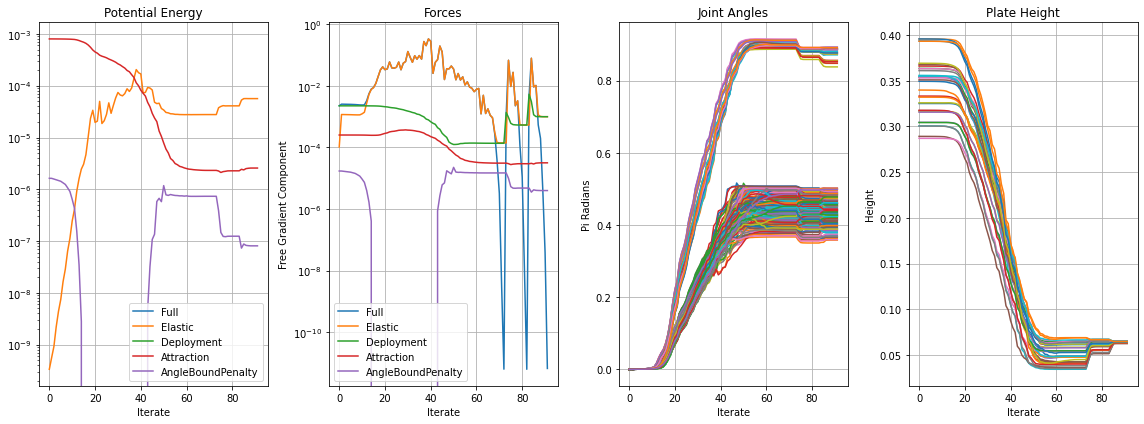

In [31]:
eqays.plot()

In [32]:
allGradientNorms(curr_um)

{'Full': 6.645340389095093e-12,
 'Elastic': 0.000993514303911456,
 'Deployment': 0.0009930052069313433,
 'Repulsion': 0.0,
 'Attraction': 3.155228587068781e-05,
 'AngleBoundPenalty': 3.972982214024516e-06}

### Initialize Design Optimization

In [33]:
allEnergies(curr_um)

{'Full': -3.199938519885228,
 'Elastic': 5.636480338407643e-05,
 'Deployment': -3.1999975365579614,
 'Repulsion': 0.0,
 'Attraction': 2.571007046064781e-06,
 'AngleBoundPenalty': 8.086230327586237e-08}

In [34]:
curr_um.attractionWeight = 1e-3

In [35]:
import umbrella_optimization
import umbrella_optimization_finite_diff

In [36]:
import py_newton_optimizer
opt_opts = py_newton_optimizer.NewtonOptimizerOptions()
opt_opts.gradTol = 1e-8
opt_opts.verbose = 1
opt_opts.beta = 1e-6
opt_opts.niter = 600
opt_opts.verboseNonPosDef = False

In [37]:
results = umbrella_mesh.compute_equilibrium(curr_um, callback = eqm_callback, options = opt_opts, fixedVars = fixedVars, elasticEnergyIncreaseFactorLimit=2.5)

0	-3.19994	3.12368e-05	3.12368e-05	1	1
1	-3.19994	1.33397e-05	1.33397e-05	1	1
2	-3.19994	3.65776e-05	3.65776e-05	1	1
3	-3.19994	0.000127248	0.000127248	1	1
4	-3.19994	0.000437042	0.000437042	0.25	0
5	-3.19994	0.0305634	0.0305634	1	0
6	-3.19994	0.00598323	0.00598323	0.5	0
7	-3.19994	0.0218714	0.0218714	1	0
8	-3.19995	0.00405382	0.00405382	0.5	0
9	-3.19995	0.0137141	0.0137141	1	0
10	-3.19995	0.0033972	0.0033972	0.5	0
11	-3.19995	0.00717342	0.00717342	1	0
12	-3.19995	0.00424895	0.00424895	1	0
13	-3.19995	0.00771961	0.00771961	1	0
14	-3.19995	0.00322564	0.00322564	1	0
15	-3.19995	0.00559445	0.00559445	1	0
16	-3.19995	0.0024034	0.0024034	1	0
17	-3.19995	0.00147749	0.00147749	0.5	0
18	-3.19995	0.00141035	0.00141035	1	0
19	-3.19995	0.000588884	0.000588884	0.5	0
20	-3.19995	0.000988488	0.000988488	1	0
21	-3.19995	0.000528499	0.000528499	0.5	0
22	-3.19995	0.000719761	0.000719761	1	0
23	-3.19995	0.000579658	0.000579658	1	0
24	-3.19995	0.00088749	0.00088749	1	0
25	-3.19995	0.00046475	0.00046475	0

In [38]:
opt_opts.niter = 25

In [39]:
results.success

True

In [40]:
optimizer = umbrella_optimization.UmbrellaOptimization(curr_um, opt_opts, 2.5, -1, False, fixedVars)

In [41]:
optimizer.beta = 5 * 1e5
optimizer.gamma = 1
optimizer.eta = 0
optimizer.zeta = 0 # 10

In [42]:
rest_height_optimizer = umbrella_optimization.UmbrellaRestHeightsOptimization(optimizer)
single_rest_height_optimizer = umbrella_optimization.UmbrellaSingleRestHeightOptimization(rest_height_optimizer)

In [43]:
allDesignObjectives(rest_height_optimizer)

{'DeploymentForce': 0.0,
 'ElasticEnergy': 1.0000000000000018,
 'Stress': 0.0,
 'TargetFitting': 21.47659859190367,
 'Full': 22.476598591903674}

In [44]:
allDesignGradientNorms(rest_height_optimizer)

{'Full': 12678.729275339656,
 'Elastic': 21.449737028107894,
 'Target': 12687.333195364452,
 'DeploymentForce': 0.0,
 'Stress': 0.0}

In [45]:
original_design_parameters = rest_height_optimizer.params()

In [46]:
import design_optimization_analysis
doptays = design_optimization_analysis.DesignOptimizationAnalysis(rest_height_optimizer)

In [47]:
import time
pipeline_helper.prev_time_stamp = time.time()

In [48]:
uo = rest_height_optimizer.get_parent_opt()

In [49]:
uo.equilibriumOptimizer.options.verbose = 1
#uo.equilibriumOptimizer.options.verboseWorkingSet = True
uo.equilibriumOptimizer.options.gradTol = 1e-10

In [50]:
tfview = pipeline_helper.TargetFittingVisualization(curr_um, uo.target_surface_fitter, view)

In [51]:
cb = pipeline_helper.UmbrellaOptimizationCallback(rest_height_optimizer, view, True, False, 1, rod_colors, doptays.record, tfview=tfview)

In [52]:
# Hold the closest points fixed in the target-attraction term of the equilibrium solve:
# this seems to make the design optimization much more robust.
uo.setHoldClosestPointsFixed(True, False)

In [53]:
# solverStatus = umbrella_optimization.optimize(rest_height_optimizer, algorithm, 100, 1.0, 1e-2, cb, input_data["plate_edge_length"] / 30 * 32 * 0.8)

In [54]:
# Adjust the trade-off between initial point fitting and target surface fitting in the design objective.
# (Note: this is distinct from the attraction term in the simulation potential energy)
uo.target_surface_fitter.scaleJointWeights(curr_um, 0.01)

In [55]:
#algorithm = umbrella_optimization.OptAlgorithm.BFGS
algorithm = umbrella_optimization.OptAlgorithm.NEWTON_CG
solverStatus = umbrella_optimization.optimize(rest_height_optimizer, algorithm, 10000, 0.0005, 1e-5, cb, -1)

In [56]:
allDesignObjectives(rest_height_optimizer)

{'DeploymentForce': 0.0,
 'ElasticEnergy': 0.8319573641563189,
 'Stress': 0.0,
 'TargetFitting': 0.45899548606427526,
 'Full': 1.2909528502205943}

In [58]:
allDesignGradientNorms(rest_height_optimizer)

{'Full': 3.0275806053049216e-06,
 'Elastic': 13.570912131043446,
 'Target': 13.570911620460365,
 'DeploymentForce': 0.0,
 'Stress': 0.0}

In [59]:
allDesignGradientNorms(rest_height_optimizer.get_parent_opt())

{'Full': 27.324549286174005,
 'Elastic': 25.490450096841187,
 'Target': 12.16461585485219,
 'DeploymentForce': 0.0,
 'Stress': 0.0}

In [ ]:
solverStatus

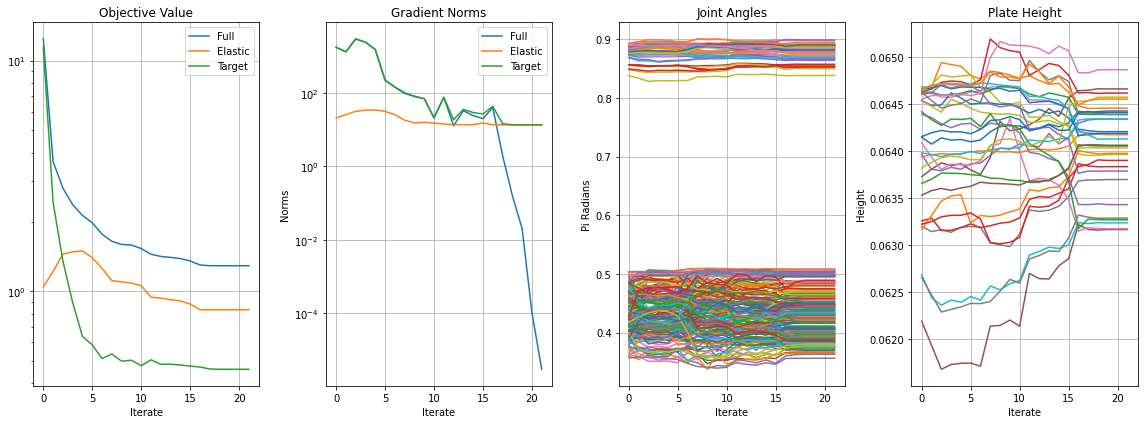

In [57]:
doptays.plot()

In [ ]:
doptays.plotEnergies(False)

### Debugging for nondifferentiable configurations

In [ ]:
uoLO = uo.linesearchObject
uoCO = uo.committedObject

In [ ]:
lview = linkage_vis.LinkageViewer(uoLO)

In [ ]:
coview = linkage_vis.LinkageViewer(uoCO, superView=lview)

In [ ]:
coview.makeOpaque('red')

In [ ]:
lview.show()

In [ ]:
coview.update()

In [ ]:
import umbrella_finite_diff
import umbrella_optimization_finite_diff

In [ ]:
p = rest_height_optimizer.params().copy()

In [ ]:
direction = np.random.normal(size=rest_height_optimizer.numParams())

In [ ]:
rest_height_optimizer.J(p)

In [ ]:
rest_height_optimizer.J(p + 1e-14 * direction)

In [ ]:
isFree = np.ones(uoLO.numDoF(), dtype=bool)
isFree[fixedVars] = False

In [ ]:
w_rhs_free = w_rhs[isFree]

In [ ]:
import scipy.sparse

In [ ]:
w[isFree]

In [ ]:
import sksparse

In [ ]:
norm(sksparse.cholmod.cholesky(H.T.tocsc()).solve_A(w_rhs[isFree]) - w[isFree]) / norm(w[isFree])

In [ ]:
norm(sksparse.cholmod.cholesky(H_perturb.T.tocsc()).solve_A(w_rhs_perturb[isFree]) - w_perturb[isFree]) / norm(w_perturb[isFree])

In [ ]:
norm(sksparse.cholmod.cholesky(H.T.tocsc()).solve_A(w_rhs_perturb[isFree]) - w_perturb[isFree]) / norm(w_perturb[isFree])

In [ ]:
np.linalg.norm(w_rhs_perturb[isFree] - w_rhs[isFree]) / np.linalg.norm(w_rhs[isFree])

In [ ]:
np.linalg.norm(w_rhs_perturb - w_rhs)

In [ ]:
etype = umbrella_optimization.OptEnergyType.Target
tsf = uo.target_surface_fitter

In [ ]:
uo.equilibriumOptimizer.options.gradTol = 1e-9
rest_height_optimizer.J(p + 1e-14 * direction)
rest_height_optimizer.J(p)
g = rest_height_optimizer.gradp_J(p, etype).copy()
g_raw = uo.gradp_J(rest_height_optimizer.applyTransformation(p), etype)
x = uo.linesearchObject.getDoFs().copy()
H = uo.linesearchObject.hessian();
H.rowColRemoval(fixedVars)
H = H.compressedColumn()
w_rhs = uo.w_rhs.copy()
w = uo.w.copy()
dJ_dxp = uo.objective.computeGrad(etype).copy()
qp = tsf.getQueryPtPos(uo.linesearchObject)
cp = tsf.umbrella_closest_surf_pts.copy()
tsfg = tsf.gradient(uo.linesearchObject)

In [ ]:
uo.equilibriumOptimizer.options.gradTol = 1e-11
rest_height_optimizer.J(p + 1e-14 * direction)
rest_height_optimizer.J(p)
g_perturb = rest_height_optimizer.gradp_J(p, etype).copy()
g_raw_perturb = uo.gradp_J(rest_height_optimizer.applyTransformation(p), etype)
x_perturb = uo.linesearchObject.getDoFs().copy()
H_perturb = uo.linesearchObject.hessian();
H_perturb.rowColRemoval(fixedVars)
H_perturb = H_perturb.compressedColumn()
w_rhs_perturb = uo.w_rhs.copy()
w_perturb = uo.w.copy()
dJ_dxp_perturb = uo.objective.computeGrad(etype).copy()
qp_perturb = tsf.getQueryPtPos(uo.linesearchObject)
cp_perturb = tsf.umbrella_closest_surf_pts.copy()
tsfg_perturb = tsf.gradient(uo.linesearchObject)

In [ ]:
from numpy.linalg import norm
print('g       ', norm(g_perturb - g) / norm(g))
print('g_raw   ', norm(g_raw_perturb - g_raw) / norm(g_raw))
print('w       ', norm(w_perturb - w) / norm(w))
print('x       ', norm(x_perturb - x) / norm(x))
print('w_rhs   ', norm(w_rhs_perturb - w_rhs) / norm(w_rhs))
print('dJ_dxp  ', norm(dJ_dxp_perturb - dJ_dxp) / norm(dJ_dxp))
print('H       ', norm(H_perturb.data - H.data) / norm(H.data))
print('qp      ', norm((qp_perturb) - (qp)) / norm(qp))
print('cp      ', norm(cp_perturb - cp) / norm(cp))
print('qp - cp ', norm((qp_perturb - cp_perturb) - (qp - cp)) / norm(qp - cp))
print('tsfg    ', norm(tsfg_perturb - tsfg) / norm(tsfg))

In [ ]:
uo.equilibriumOptimizer.options.verbose = 1
uo.equilibriumOptimizer.options.verboseWorkingSet = 1
uo.equilibriumOptimizer.options.gradTol = 1e-11
uo.equilibriumOptimizer.options.niter = 200

In [ ]:
uo.equilibriumOptimizer.options.gradTol = 1e-9

In [ ]:
uo.invalidateEquilibria()

In [ ]:
uo.setHoldClosestPointsFixed(True, True)

In [ ]:
umbrella_optimization_finite_diff.get_J_fd_error(rest_height_optimizer, 1e-6, direction, umbrella_optimization.OptEnergyType.Full)

In [ ]:
umbrella_optimization_finite_diff.gradient_convergence_plot(rest_height_optimizer, direction, umbrella_optimization.OptEnergyType.Full)

In [ ]:
umbrella_optimization_finite_diff.gradient_convergence_plot(rest_height_optimizer, direction, umbrella_optimization.OptEnergyType.Target)

In [ ]:
umbrella_optimization_finite_diff.gradient_convergence_plot(rest_height_optimizer, direction, umbrella_optimization.OptEnergyType.Elastic)

In [ ]:
umbrella_optimization_finite_diff.gradient_convergence_plot(rest_height_optimizer, direction, umbrella_optimization.OptEnergyType.Stress)

In [ ]:
# Try the FD validation again after a slight perturbation...
rest_height_optimizer.J(p + 1e-13 * direction)
uo.commitLinesearchUmbrella()

In [ ]:
from load_jsondata import update_optimized_json
update_optimized_json(input_path, rest_height_optimizer.params() * input_data['bbox_diagonal'], output_json_path = '../../output/{}_optimized_params_{}.json'.format(name, time.strftime("%Y_%m_%d_%H_%M")))

In [ ]:
rest_height_optimizer.defaultLengthBound()

In [ ]:
rest_height_optimizer.numParams()

In [ ]:
rest_height_optimizer.params() - rest_height_optimizer.defaultLengthBound()

### Visualization

In [ ]:
import importlib, pipeline_helper
importlib.reload(pipeline_helper)
from pipeline_helper import plot_objective, Visualization_Setting, get_objective_components, plot_objective_stack, get_grad_norm_components

vs = Visualization_Setting()
use_svg = False

In [ ]:
vs.figure_size = (10, 6)

In [ ]:
import matplotlib.pyplot as plt

#### Objective

In [ ]:
opt_objective_elastic, opt_objective_target, opt_objective_deployment, opt_total_objective, colors, labels = get_objective_components(cb.iterateData, vs)

In [ ]:
plot_objective(vs, opt_total_objective, '{}_objective.{}'.format(name, 'svg' if use_svg else 'png'), "Optimization")

In [ ]:
plot_objective_stack(vs, opt_total_objective, [opt_objective_elastic, opt_objective_target, opt_objective_deployment], colors, labels, '{}_objective_stack.{}'.format(name, 'svg' if use_svg else 'png'), "Optimization")

In [ ]:
objective_components_list = [opt_objective_elastic, opt_objective_target, opt_objective_deployment]
label_list = labels
color_list = colors
grad_norm = False

In [ ]:
fig, host = plt.subplots()
cmap = plt.get_cmap("Set2")
x=range(len(opt_total_objective))
y=np.array(opt_total_objective)

plt.plot(x,y)
fig.set_size_inches(vs.figure_size)
plt.ylabel('Grad Norm' if grad_norm else 'Objective Value', fontsize = vs.figure_label_size)
plt.title('Objective', fontsize = vs.figure_label_size)
fig.set_size_inches(vs.figure_size)

In [ ]:
fig, host = plt.subplots()
fig.set_size_inches(vs.figure_size)

x=range(len(opt_total_objective))
y=np.array(objective_components_list)

# Basic stacked area chart.
plt.stackplot(x,y, labels=label_list, colors = color_list, baseline='zero')
plt.legend(loc='upper right', prop={'size': 15}, fancybox=True)
plt.ylabel('Grad Norm' if grad_norm else 'Objective Value', fontsize = vs.figure_label_size)
plt.title("Optimization Objective", fontsize = vs.figure_label_size)

#### Gradient Norm

In [ ]:
opt_grad_norm_elastic, opt_grad_norm_target, opt_grad_norm_deployment, opt_total_grad_norm, colors, labels = get_grad_norm_components(cb.iterateData, vs)

In [ ]:
grad_norm_components_list = [opt_grad_norm_elastic, opt_grad_norm_target, opt_grad_norm_deployment]
label_list = labels
color_list = colors
grad_norm = True

In [ ]:
plot_objective(vs, opt_total_grad_norm, '{}_objective_grad_norm.{}'.format(name, 'svg' if use_svg else 'png'), "Optimization", grad_norm=grad_norm)

In [ ]:
plot_objective_stack(vs, opt_total_grad_norm, [opt_grad_norm_elastic, opt_grad_norm_target, opt_grad_norm_deployment], colors, labels, '{}_objective_grad_norm_stack.{}'.format(name, 'svg' if use_svg else 'png'), "Optimization Gradient Norm", grad_norm=grad_norm)

In [ ]:
fig, host = plt.subplots()
cmap = plt.get_cmap("Set2")
x=range(len(opt_total_grad_norm))
y=np.array(opt_total_grad_norm)

plt.plot(x,y)
fig.set_size_inches(vs.figure_size)
plt.ylabel('Grad Norm' if grad_norm else 'Objective Value', fontsize = vs.figure_label_size)
plt.title('Grad Norm', fontsize = vs.figure_label_size)
fig.set_size_inches(vs.figure_size)

In [ ]:
fig, host = plt.subplots()
fig.set_size_inches(vs.figure_size)

x=range(len(opt_total_grad_norm))
y=np.array(grad_norm_components_list)

# Basic stacked area chart.
plt.stackplot(x,y, labels=label_list, colors = color_list, baseline='zero')
plt.legend(loc='upper right', prop={'size': 15}, fancybox=True)
plt.ylabel('Grad Norm' if grad_norm else 'Objective Value', fontsize = vs.figure_label_size)
plt.title("Optimization Gradient Norm", fontsize = vs.figure_label_size)

### Undeployment

In [ ]:
use_pin = True

In [ ]:
driver = curr_um.centralJoint()
jdo = curr_um.dofOffsetForJoint(driver)
fixedVars = (list(range(jdo, jdo + 6)) if use_pin else []) + curr_um.rigidJointAngleDoFIndices()

In [ ]:
# curr_um.uniformDeploymentEnergyWeight = 1e-3
curr_um.uniformDeploymentEnergyWeight = 0
curr_um.targetDeploymentHeight = thickness * 50
curr_um.repulsionEnergyWeight = 0
curr_um.attractionWeight = 0
curr_um.setHoldClosestPointsFixed(False)
curr_um.scaleInputPosWeights(1)

In [ ]:
allEnergies(curr_um)

In [ ]:
OPTS.niter = 10

In [ ]:
results = umbrella_mesh.compute_equilibrium(curr_um, callback = eqm_callback, options = OPTS, fixedVars = fixedVars, elasticEnergyIncreaseFactorLimit=2.5)

In [ ]:
results.success

In [ ]:
allEnergies(curr_um)

In [ ]:
curr_um.uniformDeploymentEnergyWeight = 0.

In [ ]:
results = umbrella_mesh.compute_equilibrium(curr_um, callback = eqm_callback, options = OPTS, fixedVars = fixedVars, elasticEnergyIncreaseFactorLimit=2.5)

In [ ]:
results.success

In [ ]:
allEnergies(curr_um)

In [ ]:
# for i in range(curr_um.numJoints()):
#     print(curr_um.joint(i).alpha)

In [ ]:
view.show()

In [ ]:
import pickle 
import gzip

pickle.dump(curr_um, gzip.open('{}_optimized_equilibrium_{}.pkl.gz'.format(name, time.strftime("%Y_%m_%d_%H_%M")), 'w'))
# load_um = pickle.load(gzip.open('test_pickle_um.pkl.gz', 'r'))